In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
##import opendatasets as od
##od.download("https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation", force=True, data_dir="./drive/MyDrive/")

#!cp -r drive/MyDrive/uw-madison-gi-tract-image-segmentation/ . 

In [ ]:
# imports & constants needed for preprocessing

import pandas as pd
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle
import cv2
import torch
from torch.utils.data import Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

SIZE = (224, 224)

In [ ]:
# load train dataframe
# this dataframe contains three entries for the same image, each one corresponding to an organ
# if 'segmentation' is NaN it means the mask for the organ of the entry is absent
# we have to deal with scans having multiple masks
df = pd.read_csv('uw-madison-gi-tract-image-segmentation/train.csv')
print(df.shape), df.head()

(115488, 3)


(None,                          id        class segmentation
 0  case123_day20_slice_0001  large_bowel          NaN
 1  case123_day20_slice_0001  small_bowel          NaN
 2  case123_day20_slice_0001      stomach          NaN
 3  case123_day20_slice_0002  large_bowel          NaN
 4  case123_day20_slice_0002  small_bowel          NaN)

In [ ]:
# extracting paths of images from train folder
TRAIN_DIR="uw-madison-gi-tract-image-segmentation/train"
all_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)

id_from_path_list = []
for i in range(0, len(all_train_images)):
    splitted_path = all_train_images[i].split("/")
    id_path = splitted_path[3] + "_" + splitted_path[5][0:10] 
    id_from_path_list.append(id_path)

id_path_df = pd.DataFrame()
id_path_df['id'] = id_from_path_list
id_path_df['path'] = all_train_images

# add exact input path for each image in the dataframe
partial_df = pd.merge(df, id_path_df, on="id", how="inner")

# Creating new columns height and width from the path details of images
partial_df["width"] = partial_df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
partial_df["height"] = partial_df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))

#DROP WIDTH, HEIGHT IF NEEDED

partial_df.sample(7)

,id,class,segmentation,path,width,height
100405,case78_day18_slice_0013,small_bowel,NaN,uw-madison-gi-tract-image-segmentation/train/c...,360,310
45472,case154_day14_slice_0070,small_bowel,23059 5 23323 8 23588 10 23853 12 24118 14 243...,uw-madison-gi-tract-image-segmentation/train/c...,266,266
36574,case113_day16_slice_0128,small_bowel,NaN,uw-madison-gi-tract-image-segmentation/train/c...,360,310
72528,case35_day12_slice_0065,large_bowel,24139 4 24414 7 24689 9 24701 11 24965 24 2500...,uw-madison-gi-tract-image-segmentation/train/c...,276,276
111459,case2_day2_slice_0098,large_bowel,18212 6 18474 16 18496 6 18739 30 19003 34 192...,uw-madison-gi-tract-image-segmentation/train/c...,266,266
29108,case125_day16_slice_0119,stomach,NaN,uw-madison-gi-tract-image-segmentation/train/c...,266,266
68737,case136_day25_slice_0113,small_bowel,45877 6 46233 13 46591 17 46950 19 47282 7 473...,uw-madison-gi-tract-image-segmentation/train/c...,360,310


In [ ]:
final_df = pd.DataFrame({'id': partial_df['id'][::3]})

final_df.head()

,id
0,case123_day20_slice_0001
3,case123_day20_slice_0002
6,case123_day20_slice_0003
9,case123_day20_slice_0004
12,case123_day20_slice_0005


In [ ]:
# Adding the segementations directly to the class object they belong to
final_df['large_bowel'] = partial_df['segmentation'][::3].values
final_df['small_bowel'] = partial_df['segmentation'][1::3].values
final_df['stomach'] = partial_df['segmentation'][2::3].values

final_df['path'] = partial_df['path'][::3].values
final_df['width'] = partial_df['width'][::3].values
final_df['height'] = partial_df['height'][::3].values

final_df.head()

,id,large_bowel,small_bowel,stomach,path,width,height
0,case123_day20_slice_0001,NaN,NaN,NaN,uw-madison-gi-tract-image-segmentation/train/c...,266,266
3,case123_day20_slice_0002,NaN,NaN,NaN,uw-madison-gi-tract-image-segmentation/train/c...,266,266
6,case123_day20_slice_0003,NaN,NaN,NaN,uw-madison-gi-tract-image-segmentation/train/c...,266,266
9,case123_day20_slice_0004,NaN,NaN,NaN,uw-madison-gi-tract-image-segmentation/train/c...,266,266
12,case123_day20_slice_0005,NaN,NaN,NaN,uw-madison-gi-tract-image-segmentation/train/c...,266,266


In [ ]:
final_df.reset_index(inplace=True,drop=True)
final_df.fillna('',inplace=True); 
final_df['mask_count'] = np.sum(final_df.iloc[:,1:4]!='',axis=1).values

final_df.head()

,id,large_bowel,small_bowel,stomach,path,width,height,mask_count
0,case123_day20_slice_0001,,,,uw-madison-gi-tract-image-segmentation/train/c...,266,266,0
1,case123_day20_slice_0002,,,,uw-madison-gi-tract-image-segmentation/train/c...,266,266,0
2,case123_day20_slice_0003,,,,uw-madison-gi-tract-image-segmentation/train/c...,266,266,0
3,case123_day20_slice_0004,,,,uw-madison-gi-tract-image-segmentation/train/c...,266,266,0
4,case123_day20_slice_0005,,,,uw-madison-gi-tract-image-segmentation/train/c...,266,266,0


0    21906
2    10921
3     3201
1     2468
Name: mask_count, dtype: int64

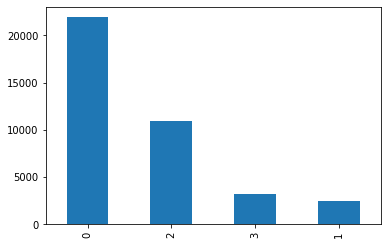

In [ ]:
final_df['mask_count'].value_counts().plot(kind='bar')
final_df["mask_count"].value_counts()

In [ ]:
final_df = final_df[(final_df["large_bowel"] != '') | 
                    (final_df["small_bowel"] != '') |
                    (final_df["stomach"] != '')]

final_df.reset_index(inplace=True,drop=True)

print(final_df.shape)        
final_df.head()

(16590, 8)


,id,large_bowel,small_bowel,stomach,path,width,height,mask_count
0,case123_day20_slice_0065,,,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,uw-madison-gi-tract-image-segmentation/train/c...,266,266,1
1,case123_day20_slice_0066,,,27561 8 27825 11 28090 13 28355 14 28620 15 28...,uw-madison-gi-tract-image-segmentation/train/c...,266,266,1
2,case123_day20_slice_0067,,,15323 4 15587 8 15852 10 16117 11 16383 12 166...,uw-madison-gi-tract-image-segmentation/train/c...,266,266,1
3,case123_day20_slice_0068,,,14792 5 15056 9 15321 11 15587 11 15852 13 161...,uw-madison-gi-tract-image-segmentation/train/c...,266,266,1
4,case123_day20_slice_0069,,,14526 6 14789 12 15054 14 15319 16 15584 17 15...,uw-madison-gi-tract-image-segmentation/train/c...,266,266,1


In [ ]:
def show_organ_balancing(dataframe):
  x_organs = [1,2,3]
  y_organs = [0, 0, 0]

  y_organs[0] = len(dataframe[dataframe["large_bowel"] != ''])
  y_organs[1] = len(dataframe[dataframe["small_bowel"] != ''])
  y_organs[2] = len(dataframe[dataframe["stomach"] != ''])
  plt.figure(figsize=(5,2), dpi=150)
  bar = plt.bar(x_organs, y_organs)
  labels=["large bowel","small bowel","stomach"]
  plt.xticks(x_organs, labels)
  plt.show()

def show_count_balancing(dataframe):
  x_count = [1,2,3]
  y_count = [0, 0, 0]
  y_count[0] = len(dataframe[dataframe["mask_count"] == 1])
  y_count[1] = len(dataframe[dataframe["mask_count"] == 2])
  y_count[2] = len(dataframe[dataframe["mask_count"] == 3])
  plt.figure(figsize=(5,2), dpi=150)
  bar = plt.bar(x_count, y_count)
  plt.xticks(x_count)
  plt.show()

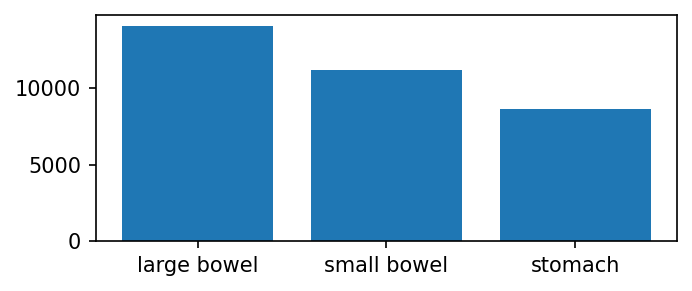

In [ ]:
show_organ_balancing(final_df)

# we have to maintain this balancing in the test/validation sets
# we will perform data augmentation only on the training set, balancing
# the occurrences of masks for the 3 organs

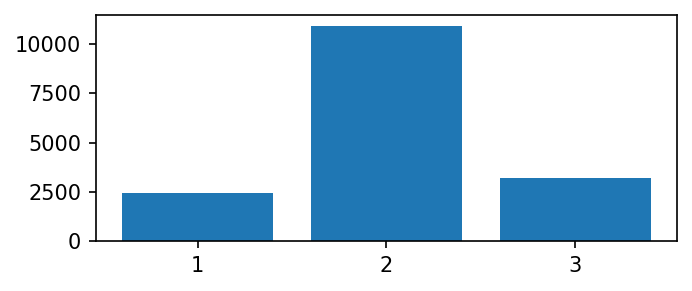

In [ ]:
show_count_balancing(final_df)

In [ ]:
def calc_organ_class(x):
  organs = []
  if x['stomach'] != '':
    organs.append('stomach')
  if x['small_bowel'] != '':
    organs.append('small_bowel')
  if x['large_bowel'] != '':
    organs.append('large_bowel')

  return '_'.join(organs)

final_df['organs'] = final_df.apply(lambda x: calc_organ_class(x), axis=1)
final_df.sample(5)

,id,large_bowel,small_bowel,stomach,path,width,height,mask_count,organs
7690,case101_day26_slice_0064,,,32638 8 32902 11 33167 13 33432 14 33698 15 33...,uw-madison-gi-tract-image-segmentation/train/c...,266,266,1,stomach
4061,case122_day27_slice_0074,15325 3 15585 12 15848 16 16110 21 16374 25 16...,30164 7 30416 22 30681 21 30946 21 31212 20 31...,24588 9 24606 6 24853 12 24869 10 25112 34 253...,uw-madison-gi-tract-image-segmentation/train/c...,266,266,3,stomach_small_bowel_large_bowel
13489,case138_day11_slice_0084,24078 12 24325 8 24342 15 24589 12 24607 17 24...,29194 2 29458 7 29723 9 29988 11 30254 12 3051...,,uw-madison-gi-tract-image-segmentation/train/c...,266,266,2,small_bowel_large_bowel
555,case129_day20_slice_0078,40128 4 40137 9 40486 23 40845 26 41205 27 415...,41156 2 41514 6 41872 9 42231 11 42590 12 4294...,36856 6 37213 11 37570 16 37928 20 38287 29 38...,uw-madison-gi-tract-image-segmentation/train/c...,360,310,3,stomach_small_bowel_large_bowel
15210,case85_day21_slice_0118,25242 4 25506 8 25772 9 26037 10 26303 11 2656...,17676 3 17723 7 17939 8 17986 13 18203 12 1825...,,uw-madison-gi-tract-image-segmentation/train/c...,266,266,2,small_bowel_large_bowel


In [ ]:
X = final_df.drop(["mask_count", "organs"], axis=1)
y = final_df["organs"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1, shuffle=True) 

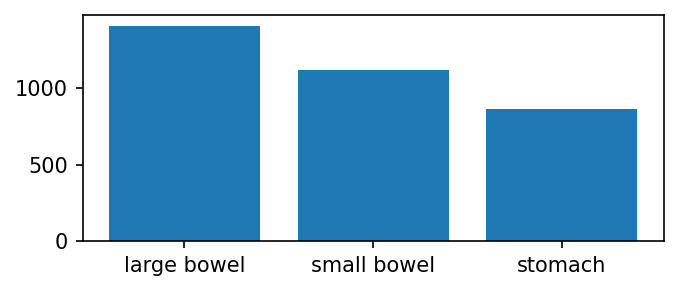

In [ ]:
# show organ balancing in test
show_organ_balancing(X_test)

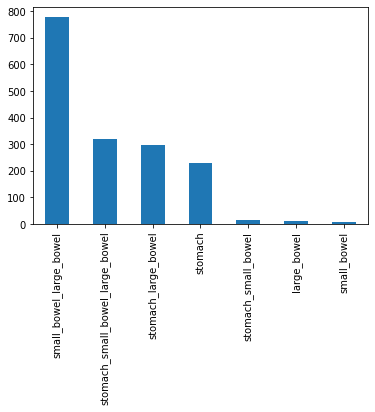

In [ ]:
# show count balancing in test
y_test.value_counts().plot(kind='bar')

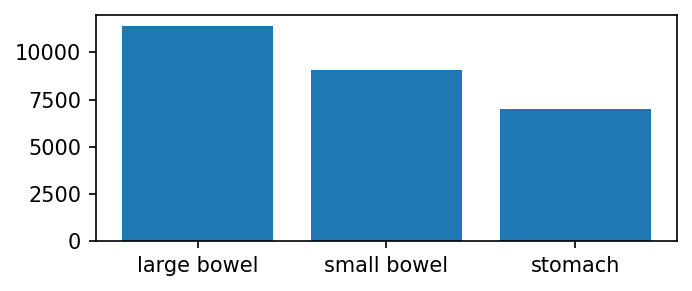

In [ ]:
# show organ balancing in train
show_organ_balancing(X_train)

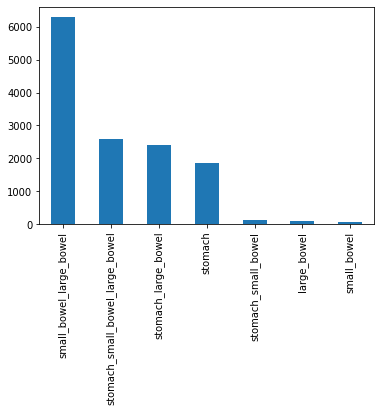

In [ ]:
# show count balancing in train
y_train.value_counts().plot(kind='bar')

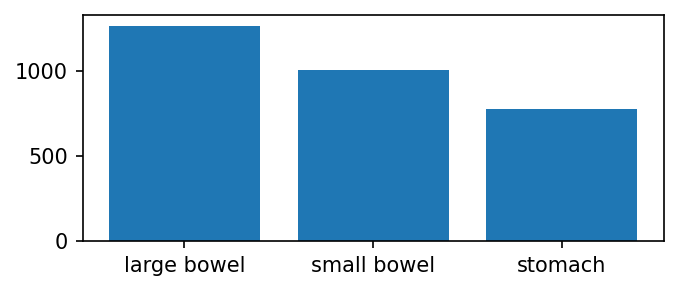

In [ ]:
# show organ balancing in validation
show_organ_balancing(X_val)

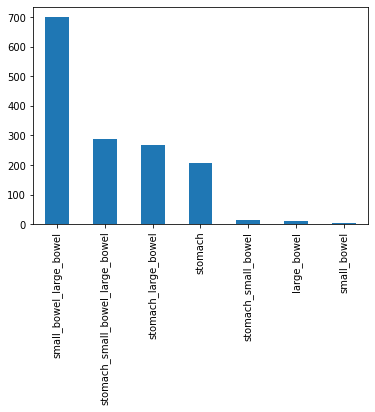

In [ ]:
# show count balancing in validation
y_val.value_counts().plot(kind='bar')

In [ ]:
X_train.head()

,id,large_bowel,small_bowel,stomach,path,width,height
9265,case124_day20_slice_0081,28568 5 28833 7 29098 9 29363 10 29629 10 2989...,33943 7 34168 3 34208 11 34433 4 34473 13 3469...,28088 11 28353 14 28617 17 28882 19 29148 20 2...,uw-madison-gi-tract-image-segmentation/train/c...,266,266
5176,case9_day0_slice_0086,22451 1 22804 10 22827 10 23163 12 23185 13 23...,27877 5 28236 7 28595 11 28955 11 29315 11 296...,,uw-madison-gi-tract-image-segmentation/train/c...,360,310
4998,case9_day22_slice_0077,20285 1 20626 10 20644 4 20985 12 21003 5 2103...,49066 3 49425 6 49784 9 50144 10 50504 11 5086...,,uw-madison-gi-tract-image-segmentation/train/c...,360,310
3528,case115_day0_slice_0098,11569 8 11831 15 11853 5 12094 21 12118 13 123...,17477 2 17720 2 17728 9 17741 6 17977 2 17983 ...,,uw-madison-gi-tract-image-segmentation/train/c...,266,266
14433,case54_day39_slice_0069,26030 4 26294 8 26560 9 26825 10 27091 10 2735...,,17719 14 17983 18 18249 20 18514 23 18779 26 1...,uw-madison-gi-tract-image-segmentation/train/c...,266,266


In [ ]:
# utility function to get a mask given a RLE encoding and a shape
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts = []
    lengths = []
    ends = []

    for i in range(0, len(s), 2):
      start_pixel = int(s[i])-1;
      starts.append(start_pixel)
      lengths.append(int(s[i+1]))
      ends.append(start_pixel + int(s[i+1]))

    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape)  

# utility function to encode a mask into RLE representation
def rle_encode(img):
    pixels = img.flatten()

    starting_point = 0;
    encoding = ''
    for i in range(0, len(pixels)):
      if (i == 0 and pixels[i] == 1) or (pixels[i-1] == 0 and pixels[i] == 1):
        starting_point = i;
        encoding += ' ' + str(starting_point + 1);

      if (pixels[i-1] == 1 and pixels[i] == 0) or (i == len(pixels) - 1 and pixels[i] == 1):
        encoding += ' ' + str(i - starting_point)

    return encoding;

# shows an image and the masks for large bowel, small bowel, stomach, with legend for clarity
def show_img(img, mask=None):
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, df, subset="train", transforms=None):
    self.df = df
    self.subset = subset
    self.transforms = transforms

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    # create a 3-tensor for the masks of the 3 organs
    masks = np.zeros((3, SIZE[0], SIZE[1]), dtype=np.float32)
    img_path=self.df['path'].iloc[index]
    width=self.df['width'].iloc[index]
    height=self.df['height'].iloc[index]
    img = self.__load_img(img_path)

    masks_list = []
    if self.subset == 'train':
        for k,j in zip([0,1,2],["large_bowel","small_bowel","stomach"]):
          # take the encoded mask of a certain index and organ
          encoded_mask = self.df[j].iloc[index]
          mask = rle_decode(encoded_mask, shape=(height, width, 1))
          mask = cv2.resize(mask, SIZE)
          # put the mask in the correct depth position
          masks_list.append(np.array(mask))
        
        # need an np.array of the img and a list of 3 np.array for the masks
        transformed = self.transforms(image=np.array(img), masks=masks_list)
        img = transformed["image"]
        masks_list = transformed["masks"]
        masks[0, :, :] = masks_list[0]
        masks[1, :, :] = masks_list[1]
        masks[2, :, :] = masks_list[2]
        #masks = transformed["masks"]
        img = img.transpose(2, 0, 1)

    if self.subset == 'train': return torch.tensor(img), torch.tensor(masks)
    else: return torch.tensor(img)

  def __load_img(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        # min-max normalization with min=0, max=255, and type unsigned 8-bit integer
        norm = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        # resize to desired dim
        img = cv2.resize(norm, SIZE)
        # replicate the image in depth 3 times -> [1 (width), 1 (height), 3 (depth)]
        # one for each possible organ
        img = np.tile(img[:, :, None], [1, 1, 3])

        return img

In [ ]:
# Example of transformations, just for a test
data_transforms = {
    "train": A.Compose([
      A.Flip(p=0.6),
      A.Rotate(limit=45, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
      A.CLAHE(clip_limit=2, p=1),
      A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0, p=0.2),
      A.GaussianBlur(sigma_limit=1, p=0.5),
    ]),
    "valid": A.Compose([
        A.Resize(*SIZE, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

In [ ]:
# get the possible organ labels in the training dataframe
# (e.g.: stomach, stomach_large_bowel, small_bowel_large_bowel, ...) 
classes = np.unique(df_train['organ'])
# count occurrences for all the classes
class_sample_count = np.array([len(np.where(df_train['organ'] == t)[0]) for t in classes])
# compute class weights, inversely proportional to class occurrence for batch balancing
class_weight = 1. / class_sample_count

weights = []
# assign class weights to each training sample in the training dataframe
for i in range(len(df_train['organ'])):
  label = df_train['organ'].iloc[i]
  idx = np.where(classes == label)[0]
  weights.append(class_weight[idx][0])

# print some weights for weighted random sampler
weights[0:10]

[0.0003856536829926726,
 0.00015867978419549348,
 0.00015867978419549348,
 0.00015867978419549348,
 0.00041425020712510354,
 0.0003856536829926726,
 0.0003856536829926726,
 0.00015867978419549348,
 0.00015867978419549348,
 0.00015867978419549348]

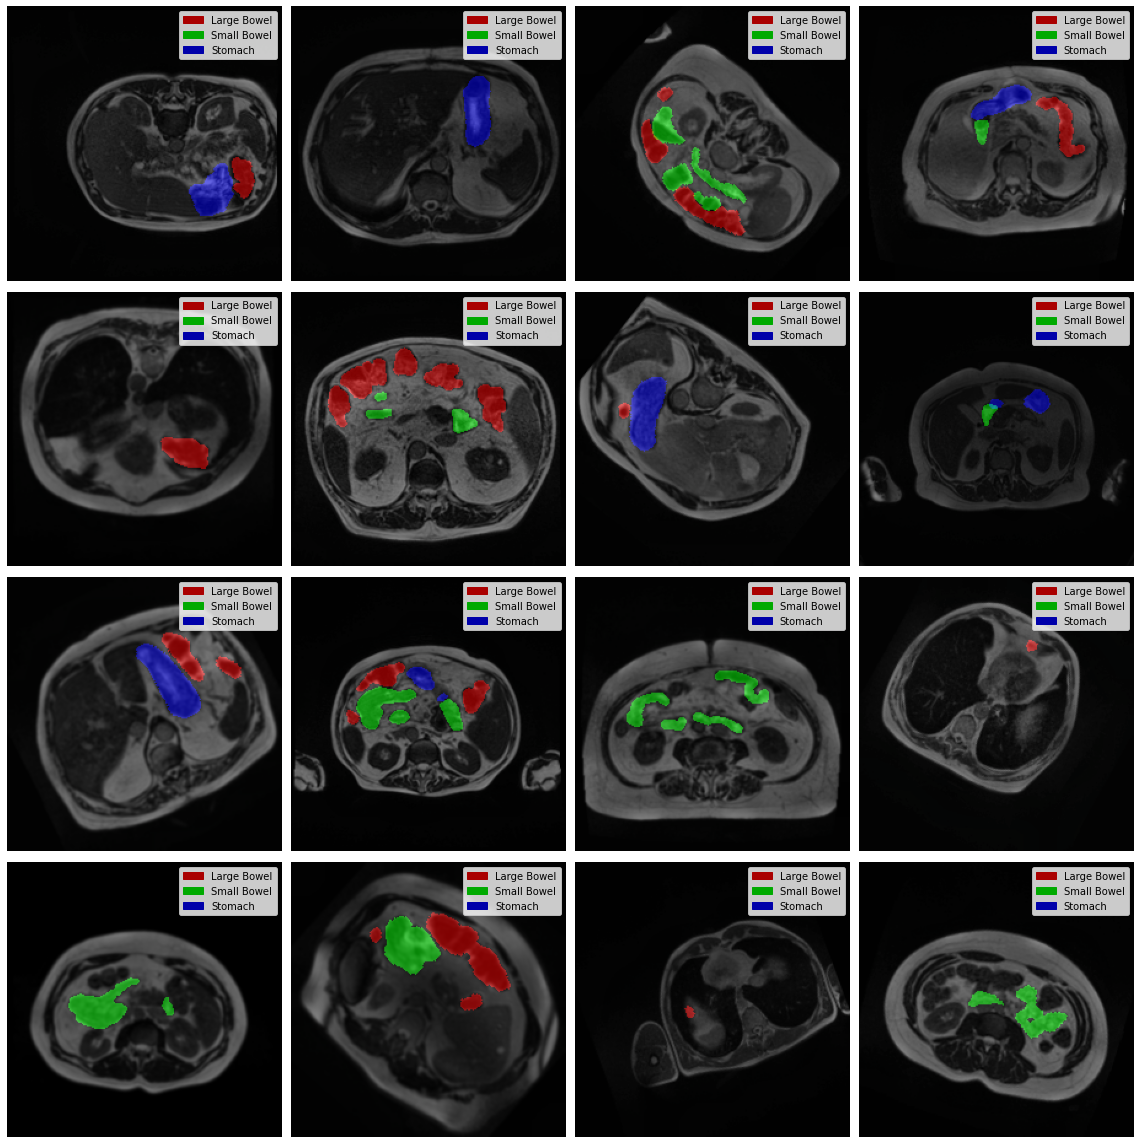

In [ ]:
# Visualize dataset
train_dataset = CustomDataset(X_train, transforms=data_transforms['train'])
valid_dataset = CustomDataset(X_val, transforms=data_transforms['valid'])
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), len(y_train))

train_loader = DataLoader(train_dataset, batch_size=64, drop_last=False, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# We get the image and mask size here
imgs, msks = next(iter(train_loader))

def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(4*4, 4*4))
    for idx in range(size):
        plt.subplot(4, 4, idx+1)
        img = imgs[idx].permute((1, 2, 0)).numpy()
        msk = msks[idx].permute((1, 2, 0)).numpy()
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

plot_batch(imgs, msks, size=16)

In [ ]:
X_train['organ'] = y_train
X_test['organ'] = y_test
X_val['organ'] = y_val
X_train.to_csv("train.csv", sep='\t', index=False)
X_test.to_csv("test.csv", sep='\t', index=False)
X_val.to_csv("validation.csv", sep='\t', index=False)

In [ ]:
df = pd.read_csv('train.csv', sep='\t')
df.head()

,id,large_bowel,small_bowel,stomach,path,width,height,organ
0,case124_day20_slice_0081,28568 5 28833 7 29098 9 29363 10 29629 10 2989...,33943 7 34168 3 34208 11 34433 4 34473 13 3469...,28088 11 28353 14 28617 17 28882 19 29148 20 2...,uw-madison-gi-tract-image-segmentation/train/c...,266,266,stomach_small_bowel_large_bowel
1,case9_day0_slice_0086,22451 1 22804 10 22827 10 23163 12 23185 13 23...,27877 5 28236 7 28595 11 28955 11 29315 11 296...,NaN,uw-madison-gi-tract-image-segmentation/train/c...,360,310,small_bowel_large_bowel
2,case9_day22_slice_0077,20285 1 20626 10 20644 4 20985 12 21003 5 2103...,49066 3 49425 6 49784 9 50144 10 50504 11 5086...,NaN,uw-madison-gi-tract-image-segmentation/train/c...,360,310,small_bowel_large_bowel
3,case115_day0_slice_0098,11569 8 11831 15 11853 5 12094 21 12118 13 123...,17477 2 17720 2 17728 9 17741 6 17977 2 17983 ...,NaN,uw-madison-gi-tract-image-segmentation/train/c...,266,266,small_bowel_large_bowel
4,case54_day39_slice_0069,26030 4 26294 8 26560 9 26825 10 27091 10 2735...,NaN,17719 14 17983 18 18249 20 18514 23 18779 26 1...,uw-madison-gi-tract-image-segmentation/train/c...,266,266,stomach_large_bowel


In [ ]:
!mkdir -p drive/MyDrive/uw-madison-gi-tract-image-segmentation/datasets

In [ ]:
!cp train.csv drive/MyDrive/uw-madison-gi-tract-image-segmentation/datasets/train.csv

In [ ]:
!cp test.csv drive/MyDrive/uw-madison-gi-tract-image-segmentation/datasets/test.csv

In [ ]:
!cp validation.csv drive/MyDrive/uw-madison-gi-tract-image-segmentation/datasets/validation.csv